In [249]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import zipfile
import os
import datetime
import socket

IS_LOCAL = socket.gethostname() in ('gabriel-notebook', 'node13-ccncluster')

if not IS_LOCAL:
    from google.colab import drive
    drive.mount('/content/drive')

if not IS_LOCAL and not os.path.exists('.unpacked'):
    print('Unpacking')
    with zipfile.ZipFile('conadcomplete.zip') as z:
        z.extractall()
    with open('.unpacked', 'w') as flag:
        flag.write(datetime.datetime.now().isoformat())

import json
import datetime
import baseline
from pprint import pprint as pp
from encoder import *
from baseline import *
from decoder import *
from alphabet import *
from data import *
from train import *
from simulation import *
from util import *
from models import *
from adapter import *
from user import *
from oneshot import *
from slack import *
import torch
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

matplotlib.rcParams['figure.figsize'] = (12, 8)

torch.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Environment variable SLACK_WEBHOOK_URL not set: Slack messages will not be sent.


'1.4.0'

In [251]:
LANGUAGE = 'Python'

ds = load_dataset('large')[LANGUAGE]
print(len(ds['train']), 'LoC in training set')

def load_json(path):
    with open(path) as f:
        return json.load(f)

interactions = load_json('interactions.json')
user_inputs = [it for it in interactions if it['type'] == 'user_input']
conventions = [(it['long'], it['short']) for it in interactions if it['type'] == 'convention']

719723 LoC in training set


In [252]:
device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
print(device)

alphabet = AsciiOneHotEncoding(device)
encoder = baseline.UniformEncoder(0.7)
decoder = AutoCompleteDecoderModel(alphabet, hidden_size=512)

encoder, decoder, alphabet, lang_name, loss_history = load_model((encoder, 0.0005, 'large', 'python'), device=device)

cpu


In [90]:
def run_experiment(name, parameters):
    u = User()
    adapter = ModelAdapter(u, encoder, decoder, alphabet, ds['train'], parameters)
    p = Progress(sum(1 for it in interactions if it['type'] == 'user_input'))

    print('Running', name)
    
    for i, it in enumerate(interactions):
        if it['type'] != 'user_input':
            continue
        long, short = it['long'], it['short']
        adapter.run_on_example(long, short)
        p.tick()

        if (i + 1) % 100 == 0:
            print(p.format())
    
    prefix = '/content/drive/My Drive/Colab/' if not IS_LOCAL else ''
    
    with open(prefix + name + '.json', 'w') as out:
        json.dump(adapter.interaction_history, out)

def get_user_inputs_using_convention(convention_id):
    return [(it['short'], it['long']) for it in user_inputs if convention_id in it['conventions']]
        
def get_interactions_using_convention(interaction_history, convention_id):
    return [it for it, pit in zip(interaction_history, user_inputs)
            if convention_id in pit['conventions']]

def get_convention(convention_id):
    last_id = -1
    
    for it in interactions:
        if it['type'] == 'convention':
            last_id += 1
            if last_id == convention_id:
                return (it['short'], it['long'])

In [ ]:
run_experiment("baseline", {'learning_rate': 1e-3, 'divergence_prior_weight': 1e-3})
run_experiment("dp", {100, 'learning_rate': 1e-3, 'divergence_prior_weight': 1e-3, 'enable_divergence_prior': True})
run_experiment("lh", {'learning_rate': 1e-3, 'divergence_prior_weight': 1e-3, 'enable_local_rehearsal': True})
run_experiment("dp+lh", {'learning_rate': 1e-3, 'divergence_prior_weight': 1e-3, 'enable_divergence_prior': True, 'enable_local_rehearsal': True})

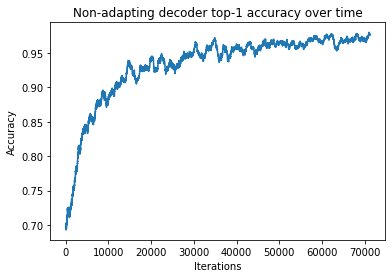

In [20]:
plt.title("Non-adapting decoder top-1 accuracy over time")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.plot(rolling_average(correct, 1000))
plt.savefig('nonadapting.png')

# Adapt to one example

In [171]:
def adapt_until_correct(parameters, encoder, decoder, alphabet, enc, dec, test, verbose=False):
    adapter = ModelAdapter(User(), encoder, decoder, alphabet, ds['train'], parameters)
    iterations = 0

    LIMIT = 100

    for i in range(LIMIT):
        success = adapter.run_on_example(dec, enc)
        if success:
            break
        if verbose:
            print(adapter.interaction_history[-1])

    if verbose:
        print('Iterations needed to solve "{}" -> "{}": {}'.format(
              enc, dec, i if success else ('> ' + str(LIMIT))))
    
    before = adapter.prior_decoder([test], alphabet)[0]
    after = adapter.adapted_decoder([test], alphabet)[0]

    return i, (before, after)

In [172]:
CONVENTION_ID = 50
EXAMPLE_INDEX = 20

enc, dec = ("self.rq = None", "self.request = None") # get_user_inputs_using_convention(CONVENTION_ID)[EXAMPLE_INDEX]
test = ("self.parameter = some_rq")
short, long = ("rq", "request") # get_convention(CONVENTION_ID)

print('Convention', short, '=>', long)
print('Example: ', enc, '=>', dec)

adapt_until_correct({'enable_adaptation': True, 'learning_rate': 1e-2},
                    encoder, decoder, alphabet, enc, dec, test, verbose=True)

Convention rq => request
Example:  self.rq = None => self.request = None
InteractionLog(line='self.request = None', encoded='self.rq = None', decoded='self.req = None')
InteractionLog(line='self.request = None', encoded='self.rq = None', decoded='self.req = None')
InteractionLog(line='self.request = None', encoded='self.rq = None', decoded='self.req = None')
InteractionLog(line='self.request = None', encoded='self.rq = None', decoded='self.req = None')
Iterations needed to solve "self.rq = None" -> "self.request = None": 4


(4, ('self.parameter = some_req', 'self.parameter = some_req'))


# One-shot learning

### Analysis on a few examples

This is just to play with learning from one example, no systematic evaluation here.

In [194]:
PARAMETERS = {'enable_adaptation': True, 'learning_rate': 1e-2}

CONVENTIONS = [
    # short, long, example_short, example_long, test_short, test_long
    ("rq", "request", "self.rq = rq", "self.request = request", "something = my_rq", "something = my_request"),
    ("ospj", "os.path.join", "path = ospj(some_list)", "path = os.path.join(some_list)", "ospj(x, y)", "os.path.join(x, y)"),
    ("npa", "np.array", "arr = npa(arr)", "arr = np.array(arr)", "np.dot(npa(x), y)", "np.dot(np.array(x), y)"),
    ("mpl", "matplotlib", "from matplotlib import pyplot as plt", "from mpl import pyplot as plt",
     "mpl.rcParams = None", "matplotlib.rcParams = None"),
]

table = []

for short, long, example_short, example_long, test_short, test_long in CONVENTIONS:
    iterations, (test_before, test_after) = adapt_until_correct(PARAMETERS, encoder, decoder, alphabet, enc, dec, test_short)
    
    table.append(("{} => {}".format(short, long),
                  "{} => {}".format(example_short, example_long),
                  "{} => {}".format(test_short, test_long),
                  iterations,
                  test_before,
                  test_after,
                  test_after == test_long))
    
pd.DataFrame(table, columns=("Expansion", "Train", "Test", "Iter.", "Test before", "Test after", "Correct?"))

,Expansion,Train,Test,Iter.,Test before,Test after,Correct?
0,rq => request,self.rq = rq => self.request = request,something = my_rq => something = my_request,6,something = my_req,something = my_req,False
1,ospj => os.path.join,path = ospj(some_list) => path = os.path.join(...,"ospj(x, y) => os.path.join(x, y)",4,"os.path.join(x, y)","os.path.join(x, y)",True
2,npa => np.array,arr = npa(arr) => arr = np.array(arr),"np.dot(npa(x), y) => np.dot(np.array(x), y)",5,"np.dot(npath(x), y)","np.dot(np.array(x), y)",True
3,mpl => matplotlib,from matplotlib import pyplot as plt => from m...,mpl.rcParams = None => matplotlib.rcParams = None,4,smpl.rcParams = None,templ.recvParams = None,False


In [ ]:
adapt_until_correct({})

In [72]:
pd.DataFrame(get_user_inputs_using_convention(50))

,0,1
0,def nb_backers(proect_page):,def nb_backers(project_page):
1,"url='https://github.com/firedrakeproect/pybench',",url='https://github.com/firedrakeproject/pyben...
2,pafy_obect = pafy.new(url),pafy_object = pafy.new(url)
3,propose = propose['reect-reason'],propose = propose['reject-reason']
4,ObectContainer.title1 = PLUGIN_TITLE,ObjectContainer.title1 = PLUGIN_TITLE
...,...,...
358,c.obect_id = fields['map_items'][0],c.object_id = fields['map_items'][0]
359,"'proect_manager_id': proect.proect_manager_id,","'project_manager_id': project.project_manager_id,"
360,"'proects',","'projects',"
361,p8_1 = ObectProperty(None),p8_1 = ObjectProperty(None)


### One-shot learning experiments

In [254]:
# Load the dataset
oneshot_dataset = load_json('oneshot_dataset.json')
print(len(oneshot_dataset), 'one-shot examples.')

def run_oneshot_experiment(evaluators, learner_creators, examples=None, save=True, save_examples=False):
    d = oneshot_dataset[:(examples or len(oneshot_dataset))]
    all_results = []
    
    for e in evaluators:
        learners = [f() for f in learner_creators]

        for l in learners:
            results = e.evaluate(l, d, save_examples=save_examples)
            all_results.append({
                'evaluator': e.name(),
                'learner': l.name(),
                'results': results,
            })
    
    if save:
        with open('results/oneshot_experiment_results_{}.json'
                  .format(datetime.datetime.now().isoformat()), 'w') as f:
            json.dump(all_results, f)
    return all_results

def get_best_result_by_metric(results, metric):
    best_learner, best_value = None, None
    
    for r in results:
        if best_value is None or r['results'][metric] > best_value:
            best_value = r['results'][metric]
            best_learner = r['learner']
            
    return best_learner, best_value

10000 one-shot examples.


In [261]:
EXAMPLES = 2

def new_k_gradient_steps(k, lr):
    return lambda: KGradientSteps(decoder, alphabet, {'k': k, 'learning_rate': lr})

def new_step_until_correct(max_steps, extra_steps, lr):
    return lambda: StepUntilCorrect(decoder, alphabet, {'max_steps': max_steps, 'extra_steps': extra_steps, 'learning_rate': lr})

evaluators = [LearnEvalIterate()] # LearnAllThenEval()

learners = [
    lambda: PriorBaseline(decoder, alphabet),
]

for lr in [0.05, 0.1, 0.2]:
    learners.append(new_k_gradient_steps(5, lr))
    
    for max_steps in [4, 8]:
        for extra in range(2, 8):
            learners.append(new_step_until_correct(max_steps, extra, lr))
try:
    results = run_oneshot_experiment(evaluators, learners, EXAMPLES, save_examples=True)
    pp(results)
    best_learner, best_pos_acc = get_best_result_by_metric(results, 'accuracy_positive')
    send_message('Grid search finished, saved all predictions to enable error analysis. Best positive accuracy: {:.2f}% (model: {})'
                 .format(best_pos_acc, best_learner))
except Exception as e:
    send_message('Error during grid search: ' + str(e))

Slack message: Error during grid search: division by zero (status: not sent - no webhook URL)


# Analyze interaction history

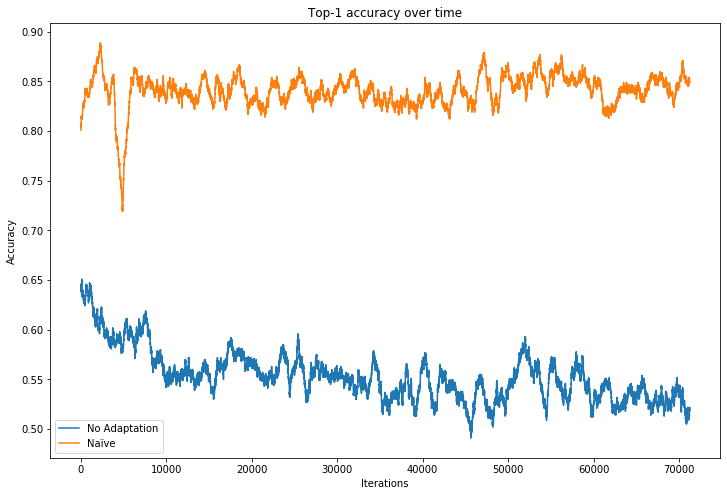

In [122]:
interaction_histories = {
    'none': ("No Adaptation", load_json('results/nonadapting.json')),
    'baseline': ("Naïve", load_json('results/baseline.json')),
#    'dp': ("DP", load_json('results/dp.json')),
#    'lh': ("LH", load_json('results/lh.json')),
#    'dp+lh': ("DP + LH", load_json('results/dp+lh.json')),
}

def plot_accuracy(plot_id, title_suffix, models, window_size=1000):    
    plt.title("Top-1 accuracy over time" + title_suffix)
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")

    for model, (name, interaction_history) in models.items():
        correct = [original == dec for original, _, dec in interaction_history]
        plt.plot(rolling_average(correct, window_size), label=name)
    
    plt.legend()
    plt.savefig('figures/accuracy-' + plot_id + '.png')
    plt.show()
    
plot_accuracy("global", "", interaction_histories)

In [130]:
def plot_average_conventions(window_size=100):
    number_of_conventions_applied = [len(it['conventions']) for it in interactions if it['type'] == 'user_input']
    plt.title("Average number of conventions used per user input")
    plt.xlabel("Iterations")
    plt.ylabel("Average conventions used")
    plt.plot(rolling_average(number_of_conventions_applied, window_size))
    plt.savefig('figures/avg-conventions-used.png')
    plt.show()

    
def plot_accuracy_by_convention(convention_id, window_size=100):
    models = {
        model_id: (title, get_interactions_using_convention(interaction_history, convention_id))
        for model_id, (title, interaction_history) in interaction_histories.items()
    }
    n_interactions = len(list(models.items())[0][1][1])
    fraction = n_interactions / len(list(interaction_histories.items())[0][1][1])
    plot_accuracy("conv-{}".format(convention_id), 
                  "[[ {} -> {} ]] ({:.2f}% coverage)".format(*get_convention(convention_id), 100*fraction),
                  models,
                  window_size)
    return

    for model_id, (model_title, interaction_history) in interaction_histories.items():
        relevant_interactions = get_interactions_using_convention(interaction_history, convention_id)
        fraction = len(relevant_interactions) / len(interaction_history)
        plot_accuracy("{}-conv{}".format(model_id, convention_id),
                      "{} on [[ {} -> {} ]] ({:.2f}% coverage)".format(model_title, *get_convention(convention_id), 100*fraction),
                      relevant_interactions,
                      window_size)


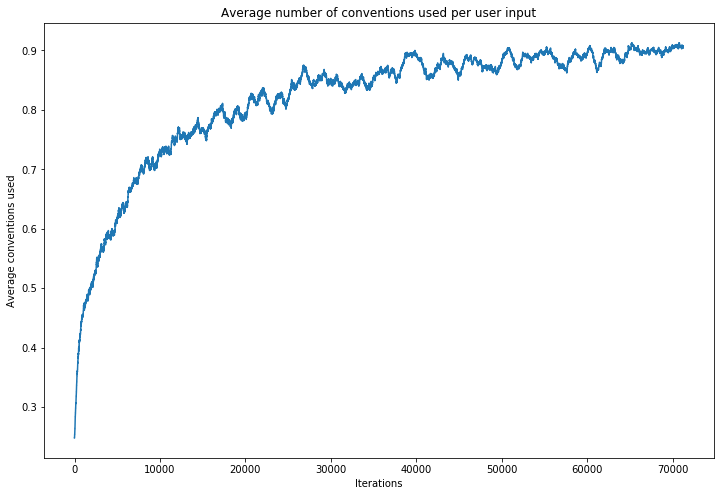

In [124]:
plot_average_conventions(1000)

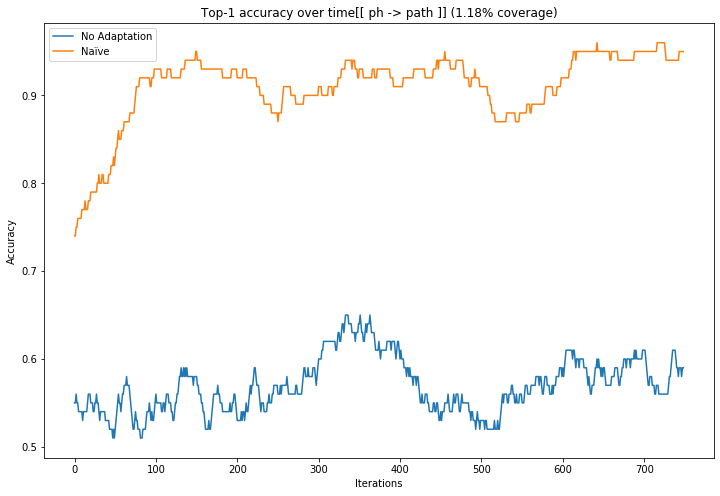

In [138]:
CONVENTION_ID = 12

plot_accuracy_by_convention(CONVENTION_ID, 100)